In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import os
import sys

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import pdist, squareform

In [2]:
MODULE_PATH = os.path.abspath('/storage/zkarwowska/SONATA_PROJECT/clean_code/data_preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit

In [17]:
file = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/male_rarefied_interpolated_feces.csv'

df = pd.read_csv(file, index_col = [0])
df = df.sort_index()
taxonomy = pd.read_csv('taxonomy/taxonomy.tsv', sep = '\t')
#filter
processing = MicrobiomeDataPreprocessing()
df_filtered = processing.filter_rare_features(df, 0.9)

In [28]:
taxonomy[['o', 'p', 'c', 'o', 'f', 'g', 's']] = taxonomy['Taxon'].str.split('; ', expand=True)

dictionary = dict(zip(taxonomy['Feature ID'], taxonomy['o']))
df_filtered_order = df_filtered.rename(columns=dictionary).T.reset_index()
df_filtered_order = df_filtered_order.groupby(by=['index']).sum().T

In [29]:
df_filtered_order = df_filtered_order.filter(like = 'o')

#### LOG CONTRAST VARIANCE MATRIX

In [30]:
df_filtered_order = df_filtered_order + 0.01
df_filtered_order_sum = df_filtered_order.div(df_filtered_order.sum(axis=1), axis=0)

In [331]:
def plot_logcontrast_variance_matrix(df, title=None):
    
    VAR1 = []
    VAR2 = []
    VARIANCE = []
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            pairwise_variance = np.var(np.log(df.iloc[:, i]/df.iloc[:, j]))
            VAR1.append(df.iloc[:, i].name)
            VAR2.append(df.iloc[:, j].name)
            VARIANCE.append(pairwise_variance)

    VARIANCE_DF = pd.DataFrame(list(zip(VAR1, VAR2, VARIANCE)), columns = ['VAR1', 'VAR2', 'VARIANCE'])
    VARIANCE_MATRIX = VARIANCE_DF.pivot(index='VAR1', columns='VAR2', values='VARIANCE')

    plt.figure(figsize = [10, 10])
    sns.heatmap(VARIANCE_MATRIX, cmap='Blues', linewidths = .9, annot=False)
    plt.show()

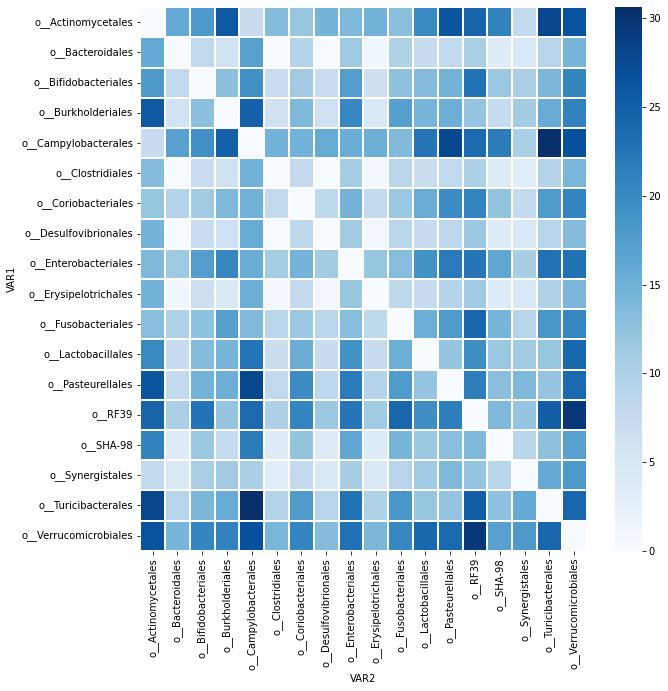

In [332]:
plot_logcontrast_variance_matrix(df_filtered_order_sum)

#### CLR VARIANCE MATRIX

In [33]:
clr_transformer = CLRTransformer(is_pseudo_global=True, axis=1)
CLR_DF = clr_transformer.fit_transform(df_filtered_order_sum)

In [329]:
def plot_clr_covariance_matrix(df, title=None):
    
    CLR_COVARIANCE_MATRIX = CLR_DF.cov()

    plt.figure(figsize = [10, 10])
    sns.heatmap(CLR_COVARIANCE_MATRIX, cmap='vlag', linewidths = .9, center = 0.0, annot=False)
    plt.show()
    return 

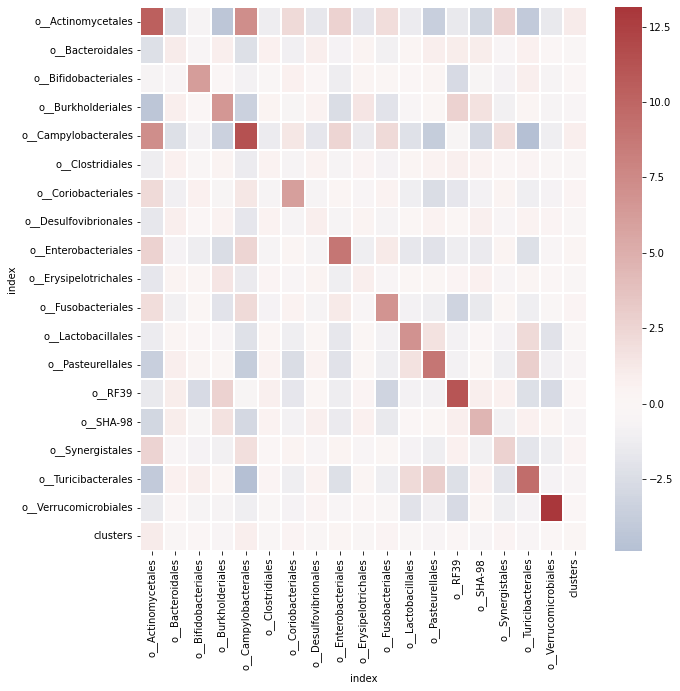

In [330]:
plot_clr_covariance_matrix(CLR_DF)

## PCA 

In [115]:
def plot_pca_biplot(df, hue_variable, standardize=False, categorical_palette = False, data_type = 'clr'):
    
    if standardize == True:
        
        scaler = StandardScaler()
        X = scaler.fit_transform(df)
        
    elif standardize == False:
        X = df
        
    if categorical_palette == True:
        
        palette = 'Set2'
    
    elif categorical_palette == False:
        palette = 'Blues'
    

    pca = PCA()
    x_new = pca.fit_transform(X)
    score = x_new[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])
    hue_variable = hue_variable
    labels = df.columns

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig = plt.figure(figsize=(15, 15))

    sns.scatterplot(x = xs * scalex, y = ys * scaley, alpha = .6, palette = palette, edgecolor = 'white', hue = hue_variable, s=80)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'black', alpha = 0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', fontsize = 12)

    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

    plt.tight_layout()
    #plt.savefig('cluster_PCA_donorA_{}.png'.format(data_type))
    plt.show()

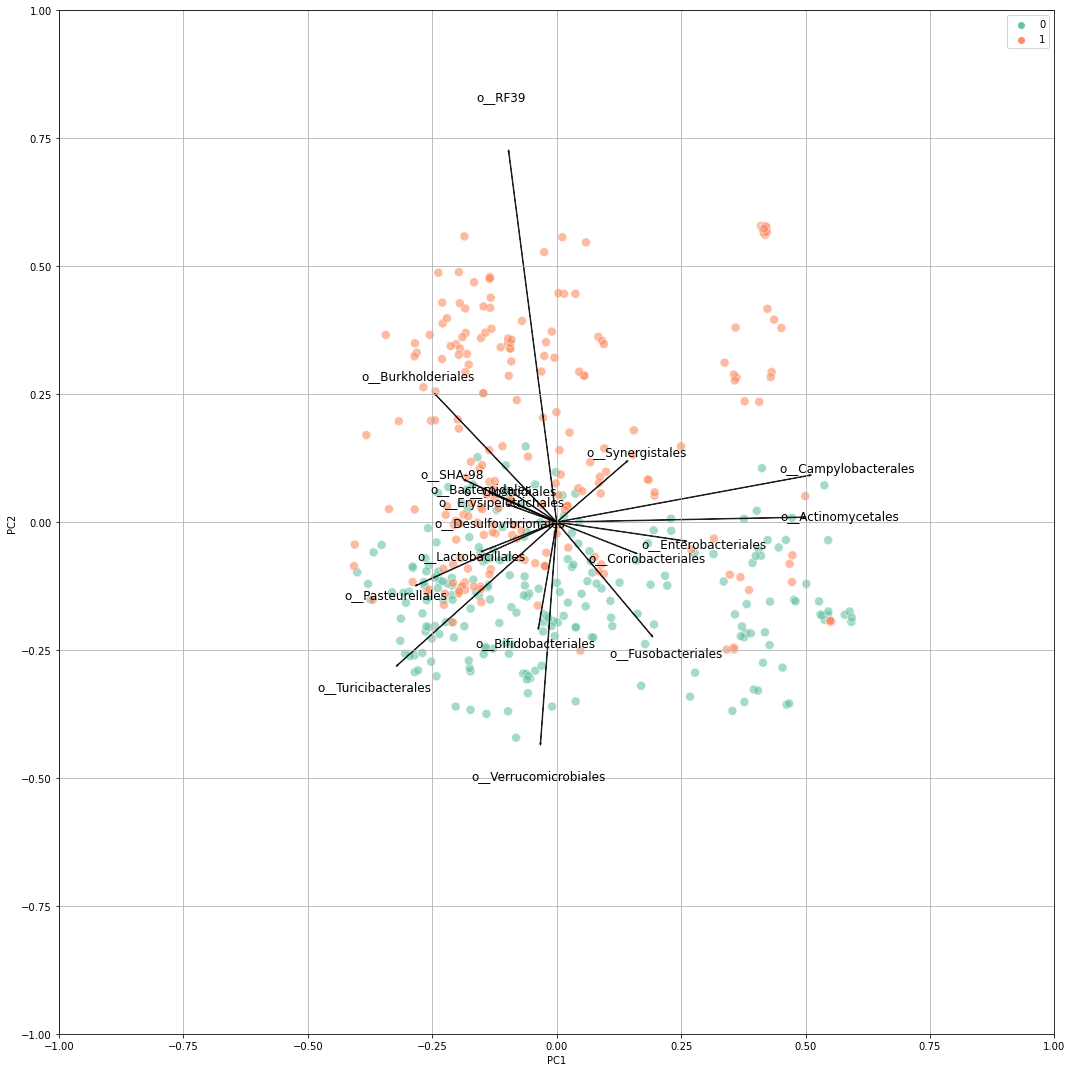

In [113]:
# PCA ON CLR RATIOS
timesteps = 222 * [0] + [1] *221
plot_pca_biplot(CLR_DF, timesteps, False, True)

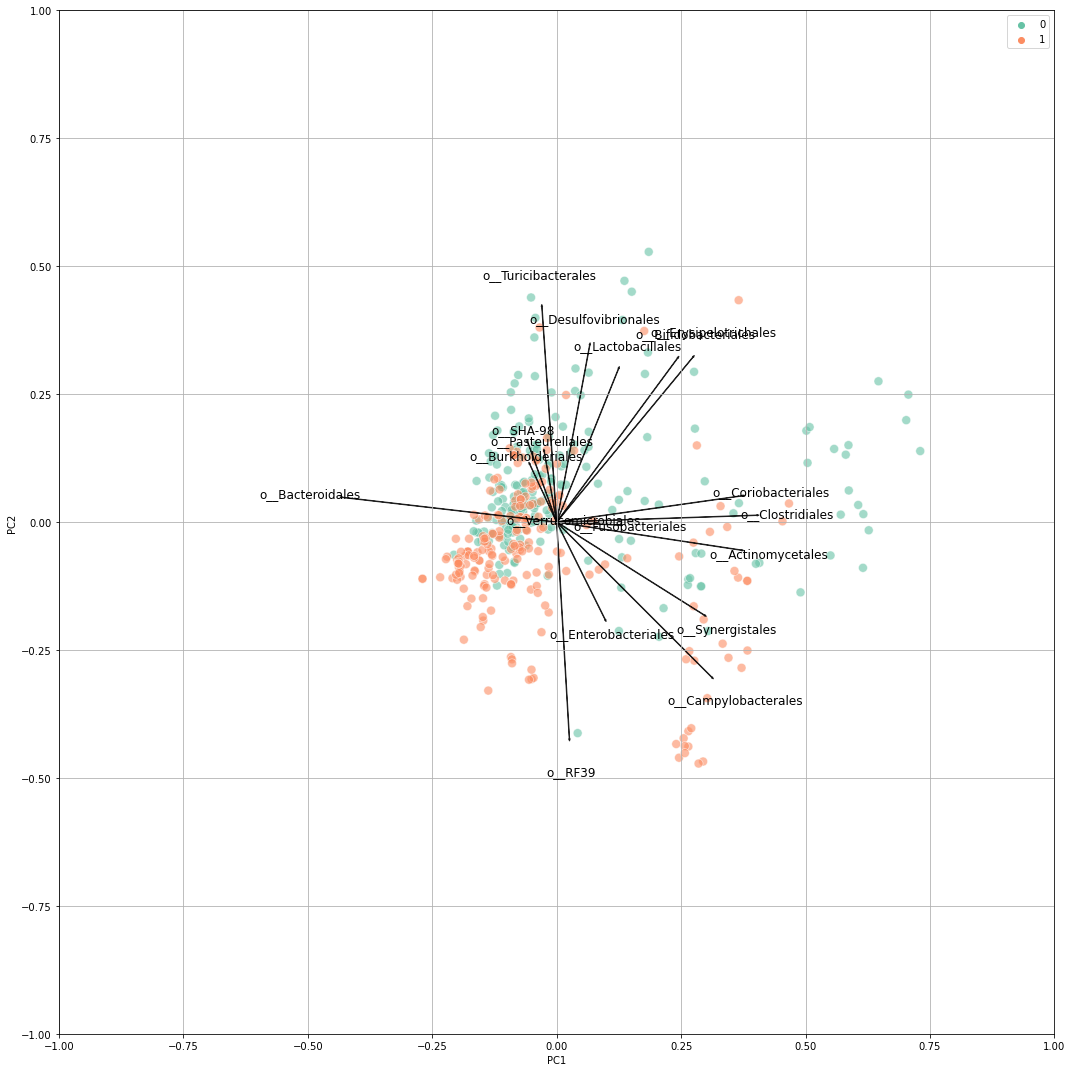

In [114]:
plot_pca_biplot(df_filtered_order, timesteps, True, True, 'counts')

## DISTANCE MATRIX 

In [87]:
def plot_distance_matrix(df, metric = 'braycurtis'):
    
    distance_matrix = squareform(pdist(df, metric = 'braycurtis'))

    plt.figure(figsize = [15, 15])
    matrix = np.triu(distance_matrix)
    sns.heatmap(distance_matrix, cmap = 'Blues', linewidth=.1)#, mask=matrix)
    plt.show()

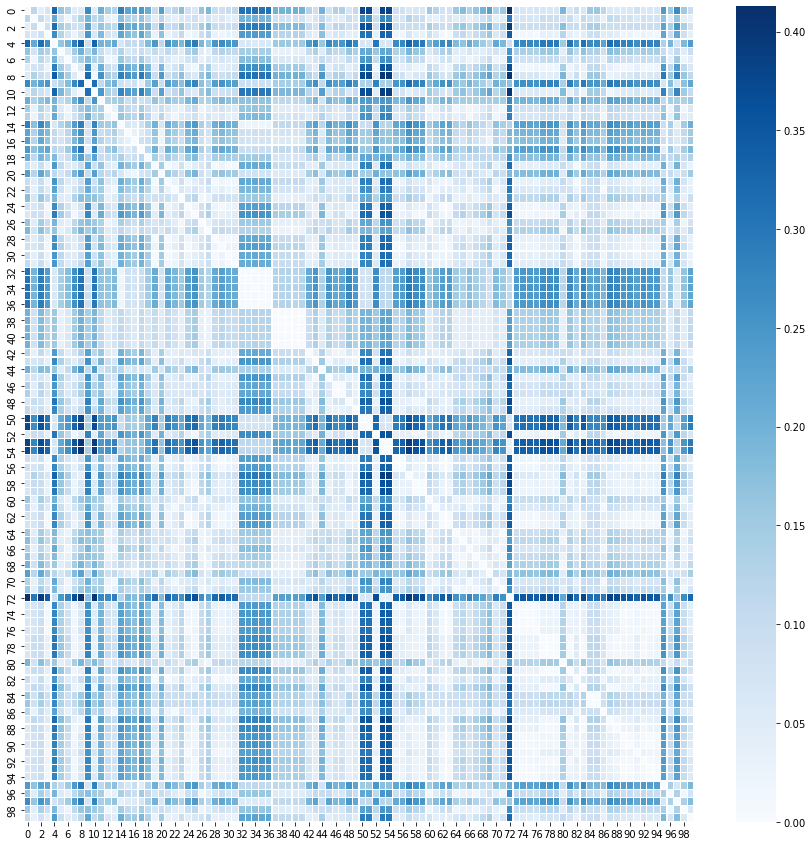

In [88]:
#RAW COUNTS
plot_distance_matrix(df_filtered_order.iloc[:100], 'euclidean')

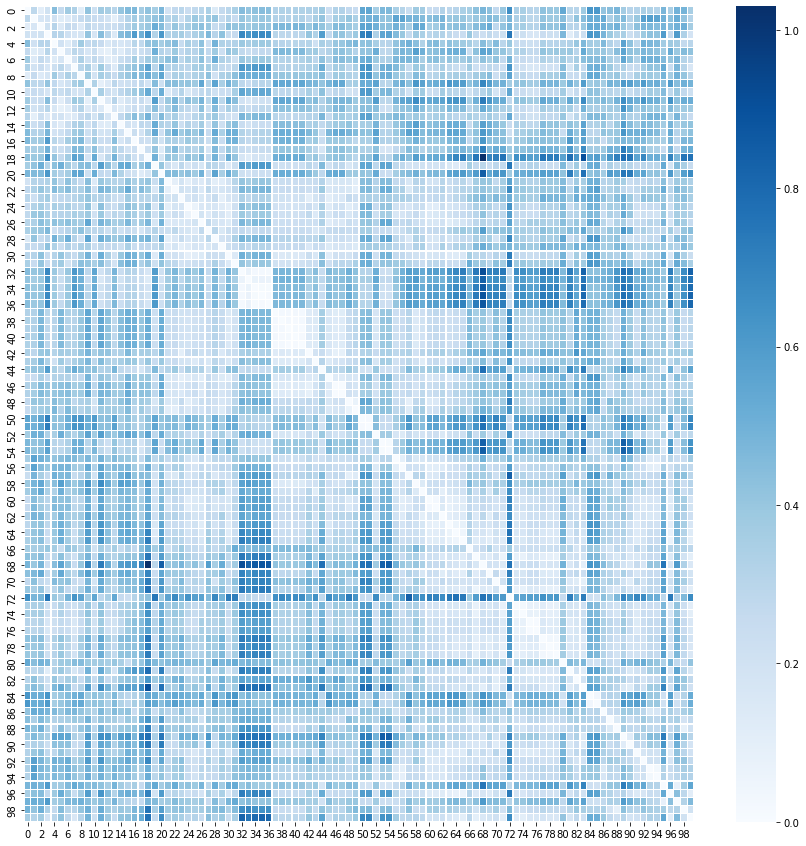

In [89]:
#CLR RATIOS
plot_distance_matrix(CLR_DF.iloc[:100], 'euclidean')

## AGGLOMERATIVE CLUSTERING

In [321]:
def assing_to_clusters(df, metric):
    
    n_clusters = 2
    
    if metric == 'braycurtis':
        
        distance_matrix = squareform(pdist(df, metric = 'braycurtis'))

        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage = 'complete')
        clustering_model.fit(distance_matrix)
        cluster_labels = clustering_model.labels_
        
    elif metric == 'euclidean':
    

        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
        clustering_model.fit(df)
        cluster_labels = clustering_model.labels_
    
    return cluster_labels

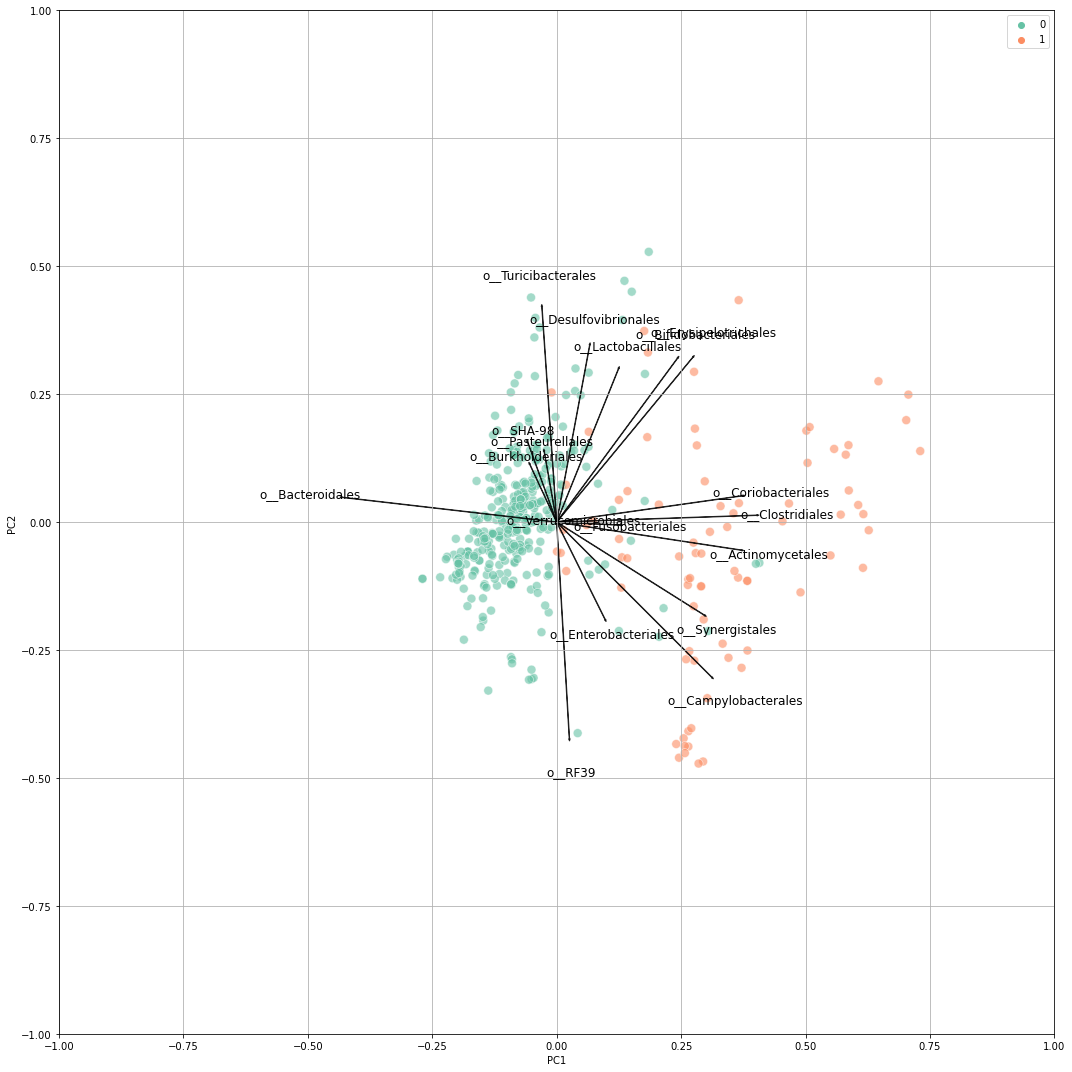

In [322]:
#RAW COUNTS
raw_clusters = assing_to_clusters(df_filtered_order, 'braycurtis')
plot_pca_biplot(df_filtered_order, raw_clusters, standardize=True, categorical_palette=True, data_type='raw')

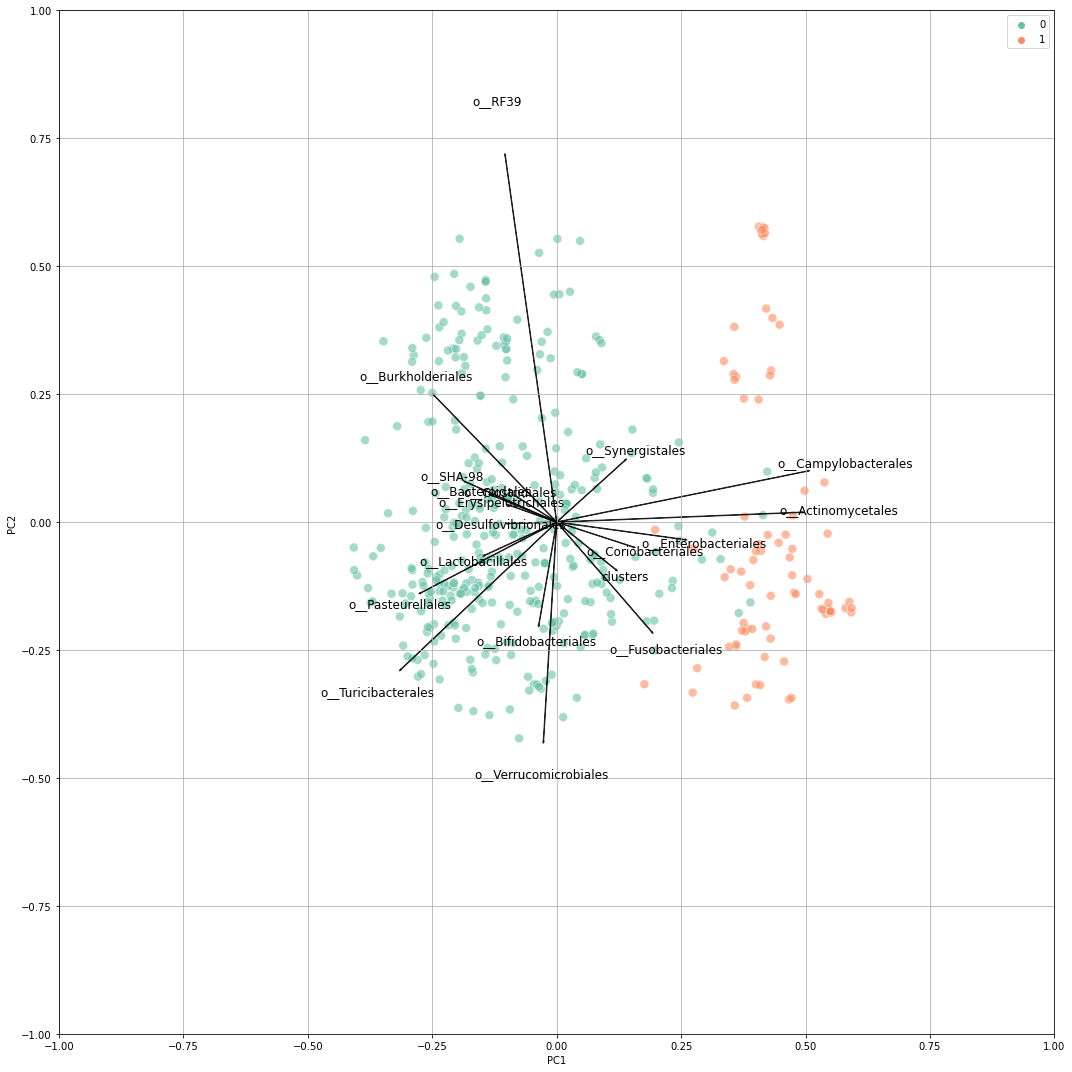

In [323]:
#CLR RATIOS
clr_clusters = assing_to_clusters(CLR_DF, 'braycurtis')
plot_pca_biplot(CLR_DF, clr_clusters, standardize=False, categorical_palette=True)

### ANALYSE CLUSTERS

In [324]:
CLR_DF['clusters'] = clr_clusters
median_clusters = CLR_DF.groupby(['clusters']).median()

In [325]:
CLUSTER_BARPLOT_DF = []
for i in set(clr_clusters):
    x = pd.DataFrame(median_clusters.iloc[i].reset_index()).rename({i:'clr', 'index':'name'}, axis=1)
    x['cluster'] = i
    #x.columns = ['name', 'clr', 'cluster']
    CLUSTER_BARPLOT_DF.append(x)
    
CLUSTER_BARPLOT_DF = pd.concat(CLUSTER_BARPLOT_DF)

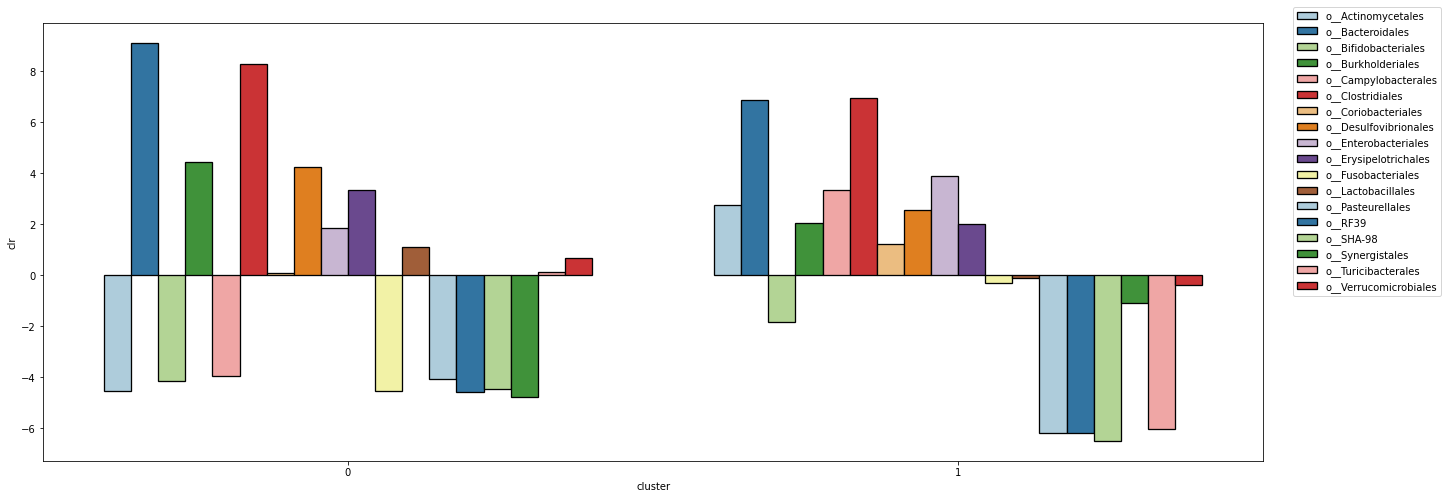

In [326]:
plt.figure(figsize = (20, 7))

sns.barplot(data = CLUSTER_BARPLOT_DF, x = 'cluster', y = 'clr', hue='name', edgecolor='black', palette='Paired', linewidth=1.3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.tight_layout()
#plt.savefig('bacteria_clusters_baplot.png')